In [45]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [46]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (np.min([Y_real.min(), Y_predicted.min()]), np.max([Y_real.max(), Y_predicted.max()]))
    plt.ylim(y_limits)
    #y_limits = (Y_real.min(), Y_real.max())
    #plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12,6.75))

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
        
    plt.plot(train_errors,  "b-.", linewidth=2, label="Training"), # color = "darkorange",
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("mse", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def plot_hours(real, predicted, targets = 1, bloques = 12):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, targets*bloques, bloques):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (12, 6.75))
    plt.plot(Y_real, color = "black", linestyle = "-", linewidth=2, label="Real")
    plt.plot(Y_predicted,  "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=14)    
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption (normalized)", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    plt.show()

# Importo los datos

In [47]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [48]:
# Selecciono las columnas para multi step forecasting.
# No quito las primeras 24h, aunque no tenga los mismos datos que en dnn

df_train = df_train.iloc[:,:-12].dropna() #todas las columnas, de y + 1 a y + 12
df_test = df_test.iloc[:,:-12].dropna()
df_train.iloc[:,:]

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,...,y + 3,y + 4,y + 5,y + 6,y + 7,y + 8,y + 9,y + 10,y + 11,y + 12
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2.83e+04,1.85e+06,23,8.63e+02,6.54e+01,4.90e+01,4.84e+03,0.00e+00,1.00e+00,1.90e+03,...,2.13e+04,2.03e+04,1.99e+04,2.00e+04,2.04e+04,2.01e+04,2.06e+04,2.22e+04,2.35e+04,2.41e+04
2015-01-01 00:00:00+00:00,2.78e+04,1.81e+06,0,9.20e+02,6.49e+01,5.00e+01,5.20e+03,0.00e+00,1.00e+00,1.66e+03,...,2.03e+04,1.99e+04,2.00e+04,2.04e+04,2.01e+04,2.06e+04,2.22e+04,2.35e+04,2.41e+04,2.47e+04
2015-01-01 01:00:00+00:00,2.68e+04,1.73e+06,1,1.16e+03,6.45e+01,5.00e+01,4.86e+03,0.00e+00,1.00e+00,1.37e+03,...,1.99e+04,2.00e+04,2.04e+04,2.01e+04,2.06e+04,2.22e+04,2.35e+04,2.41e+04,2.47e+04,2.47e+04
2015-01-01 02:00:00+00:00,2.52e+04,1.50e+06,2,1.50e+03,5.93e+01,5.00e+01,4.31e+03,0.00e+00,1.00e+00,7.79e+02,...,2.00e+04,2.04e+04,2.01e+04,2.06e+04,2.22e+04,2.35e+04,2.41e+04,2.47e+04,2.47e+04,2.35e+04
2015-01-01 03:00:00+00:00,2.46e+04,1.38e+06,3,1.83e+03,5.60e+01,4.20e+01,4.13e+03,0.00e+00,1.00e+00,7.20e+02,...,2.04e+04,2.01e+04,2.06e+04,2.22e+04,2.35e+04,2.41e+04,2.47e+04,2.47e+04,2.35e+04,2.31e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14 01:00:00+00:00,2.78e+04,1.22e+06,1,1.39e+03,4.39e+01,1.50e+01,3.75e+03,0.00e+00,1.00e+00,4.10e+03,...,2.47e+04,2.77e+04,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04
2018-03-14 02:00:00+00:00,2.77e+04,1.19e+06,2,1.32e+03,4.29e+01,1.40e+01,3.73e+03,0.00e+00,1.00e+00,4.14e+03,...,2.77e+04,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04,3.36e+04
2018-03-14 03:00:00+00:00,2.83e+04,1.21e+06,3,1.63e+03,4.27e+01,1.50e+01,4.00e+03,0.00e+00,1.00e+00,4.26e+03,...,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04,3.36e+04,3.31e+04


In [49]:
# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-12], X_Y_train[:,-12:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((21029, 14), (21029, 12), (7010, 14), (7010, 12), (7001, 14), (7001, 12))

In [50]:
# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)


X_train = X_Y_train[:,:-12]
Y_train = X_Y_train[:,-12:]

X_val = X_Y_val[:,:-12]
Y_val = X_Y_val[:,-12:]

X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

print(X_train[0], Y_train[0], X_val[0], Y_val[0]) # Compruebo que está estandarizdo

(21029, 14) (21029, 12) (7010, 14) (7010, 12) (7001, 14) (7001, 12)
[0.44065198 0.36477505 1.         0.19080256 0.54194047 0.00691683
 0.17962843 0.         1.         0.18833984 1.         0.74444444
 1.         0.31966571] [0.27600766 0.2042744  0.14124663 0.09676156 0.0811352  0.08570558
 0.10168016 0.08936189 0.1129973  0.1832071  0.23966223 0.26516932] [0.26966836 0.26538832 0.17391304 0.05460977 0.47941631 0.00760851
 0.2220782  0.         1.         0.18107932 0.         0.5
 0.72       0.32871942] [0.43309829 0.53434317 0.60329068 0.63950553 0.66727605 0.69478541
 0.69443719 0.64203012 0.60816575 0.60429181 0.60376948 0.58352921]


# Modelos de base & tabla de errores

In [51]:
# Modelos de base & tabla de errores

# mi modelo de base va a ser naive forecasting. "El consumo de hoy es el mismo que el de ayer"

# función auxiliar

def baseline_model_2(samples, columnas, previous_sample=1): # cualquier instante anterior
    
    # columnas es una lista con los targets
    # Samples es un ndarray con los targets
    # previous_sample es la muestra anterior que queremos que se devuelva
    
    df = pd.DataFrame(data = samples, columns = columnas)
    if previous_sample > len(columnas):
        return ("No hay instantes anteriores a t-"+str(previous_sample))
    
    for i in range(len(columnas)):
        df[columnas[i]+"_pred"] = df[columnas[i]].shift(previous_sample)
    
    return df.dropna()

In [52]:
baseline_model_2(Y_train, df_train.iloc[:,-12:].columns.to_list(), previous_sample=12)

,y + 1,y + 2,y + 3,y + 4,y + 5,y + 6,y + 7,y + 8,y + 9,y + 10,...,y + 3_pred,y + 4_pred,y + 5_pred,y + 6_pred,y + 7_pred,y + 8_pred,y + 9_pred,y + 10_pred,y + 11_pred,y + 12_pred
12,2.90e-01,2.89e-01,2.39e-01,2.21e-01,2.42e-01,3.66e-01,4.34e-01,4.78e-01,5.02e-01,4.78e-01,...,1.41e-01,9.68e-02,8.11e-02,8.57e-02,1.02e-01,8.94e-02,1.13e-01,1.83e-01,2.40e-01,2.65e-01
13,2.89e-01,2.39e-01,2.21e-01,2.42e-01,3.66e-01,4.34e-01,4.78e-01,5.02e-01,4.78e-01,3.81e-01,...,9.68e-02,8.11e-02,8.57e-02,1.02e-01,8.94e-02,1.13e-01,1.83e-01,2.40e-01,2.65e-01,2.90e-01
14,2.39e-01,2.21e-01,2.42e-01,3.66e-01,4.34e-01,4.78e-01,5.02e-01,4.78e-01,3.81e-01,3.93e-01,...,8.11e-02,8.57e-02,1.02e-01,8.94e-02,1.13e-01,1.83e-01,2.40e-01,2.65e-01,2.90e-01,2.89e-01
15,2.21e-01,2.42e-01,3.66e-01,4.34e-01,4.78e-01,5.02e-01,4.78e-01,3.81e-01,3.93e-01,3.00e-01,...,8.57e-02,1.02e-01,8.94e-02,1.13e-01,1.83e-01,2.40e-01,2.65e-01,2.90e-01,2.89e-01,2.39e-01
16,2.42e-01,3.66e-01,4.34e-01,4.78e-01,5.02e-01,4.78e-01,3.81e-01,3.93e-01,3.00e-01,2.25e-01,...,1.02e-01,8.94e-02,1.13e-01,1.83e-01,2.40e-01,2.65e-01,2.90e-01,2.89e-01,2.39e-01,2.21e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,2.80e-01,2.62e-01,2.51e-01,2.69e-01,3.29e-01,4.33e-01,5.34e-01,6.03e-01,6.40e-01,6.67e-01,...,6.39e-01,6.45e-01,6.21e-01,6.00e-01,5.90e-01,6.01e-01,5.48e-01,4.45e-01,3.85e-01,3.23e-01
21025,2.62e-01,2.51e-01,2.69e-01,3.29e-01,4.33e-01,5.34e-01,6.03e-01,6.40e-01,6.67e-01,6.95e-01,...,6.45e-01,6.21e-01,6.00e-01,5.90e-01,6.01e-01,5.48e-01,4.45e-01,3.85e-01,3.23e-01,2.80e-01
21026,2.51e-01,2.69e-01,3.29e-01,4.33e-01,5.34e-01,6.03e-01,6.40e-01,6.67e-01,6.95e-01,6.94e-01,...,6.21e-01,6.00e-01,5.90e-01,6.01e-01,5.48e-01,4.45e-01,3.85e-01,3.23e-01,2.80e-01,2.62e-01
21027,2.69e-01,3.29e-01,4.33e-01,5.34e-01,6.03e-01,6.40e-01,6.67e-01,6.95e-01,6.94e-01,6.42e-01,...,6.00e-01,5.90e-01,6.01e-01,5.48e-01,4.45e-01,3.85e-01,3.23e-01,2.80e-01,2.62e-01,2.51e-01


In [53]:
# Compruebo que aplicando la función de arriba los datos se me desplaan correctamente

print(baseline_model_2(Y_train, df_train.iloc[:,-12:].columns.to_list(), previous_sample=12)[["y + 1"]].iloc[0,:])
print(baseline_model_2(Y_train, df_train.iloc[:,-12:].columns.to_list(), previous_sample=12)[["y + 1_pred"]].iloc[12,:])


y + 1   2.90e-01
Name: 12, dtype: float64
y + 1_pred   2.90e-01
Name: 24, dtype: float64


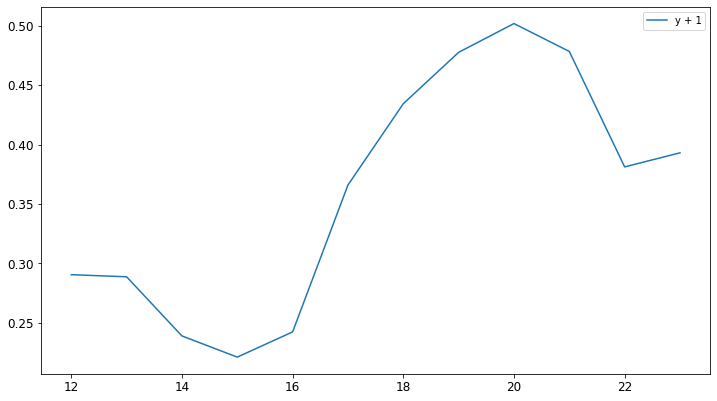

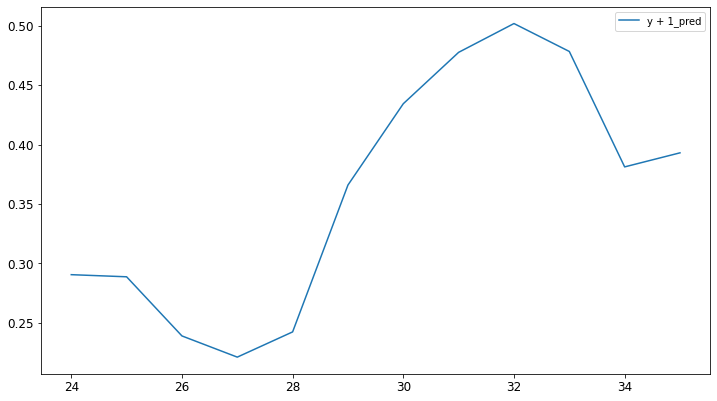

In [54]:
baseline_model_2(Y_train, df_train.iloc[:,-12:].columns.to_list(), previous_sample=12)[["y + 1"]].iloc[:12,:].plot()
baseline_model_2(Y_train, df_train.iloc[:,-12:].columns.to_list(), previous_sample=12)[["y + 1_pred"]].iloc[12:24,:].plot()

plt.show()


0.056072635570966416


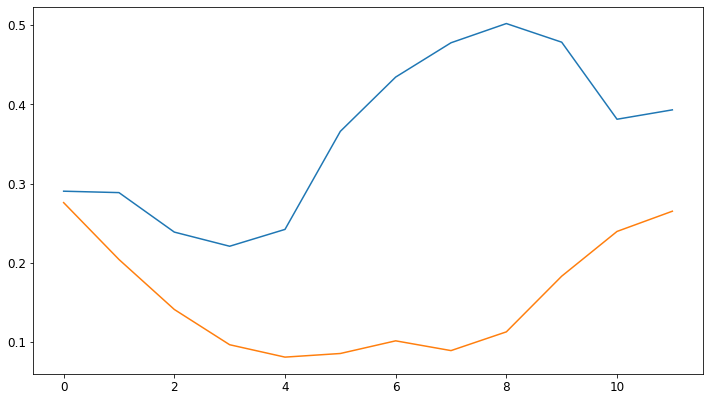

In [55]:
# Creo la predicción del modelo naive en los tres sets

# train, val, test

columnas = df_train.iloc[:,-12:].columns.to_list()

naive_train = baseline_model_2(Y_train, columnas, previous_sample = 12)
naive_val = baseline_model_2(Y_val, columnas, previous_sample = 12)
naive_test = baseline_model_2(Y_test, columnas, previous_sample = 12)

actual = naive_train.iloc[0,:-12].to_numpy()
predicted = naive_train.iloc[0,-12:].to_numpy()

plt.plot(actual)
plt.plot(predicted)

from sklearn.metrics import mean_squared_error

print(mean_squared_error(actual, predicted))


In [110]:
# creo un dataframe para guardar los errores y guardo los errores del modelo naive

from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

naive_train_errors = list()
naive_val_errors = list()
naive_test_errors = list()

for i in range(len(naive_train.index)):
    actual = naive_train.iloc[i,:-12].to_numpy()
    predicted = naive_train.iloc[i,-12:].to_numpy()
    naive_train_errors.append(mean_squared_error(actual, predicted))
for i in range(len(naive_val.index)):
    actual = naive_val.iloc[i,:-12].to_numpy()
    predicted = naive_val.iloc[i,-12:].to_numpy()
    naive_val_errors.append(mean_squared_error(actual, predicted))
for i in range(len(naive_test.index)):
    actual = naive_test.iloc[i,:-12].to_numpy()
    predicted = naive_test.iloc[i,-12:].to_numpy()
    naive_test_errors.append(mean_squared_error(actual, predicted))

naive_train_errors = np.array(naive_train_errors)
naive_val_errors   = np.array(naive_val_errors)
naive_test_errors  = np.array(naive_test_errors)

# El error total del set es la medi (o la suma, aún por decidir) de los mse de cada predicción de 24 h

errores_df.loc["naive_1h", "train mse"] = naive_train_errors.mean()
errores_df.loc["naive_1h", "val mse"] = naive_val_errors.mean()

errores_df.loc["naive_1h", "delta errores"] = errores_df.loc["naive_1h", "val mse"] - errores_df.loc["naive_1h", "train mse"]
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan


# Comienzo a probar modelos

In [57]:
# Actualizo esta función para multitarget forecasting

def ts_learning_curves(model, X_train, Y_train, X_val, Y_val, batch = 1):
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    
    start_time = time.time()
    
    iteraciones = Y_train.shape[0]
    
    for i in range(0, iteraciones, batch):
            
        X_train_slice, Y_train_slice = X_train[:i+1], Y_train[:i+1]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
            
        current_time = time.time()
    
        if i%100 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    
    if batch > 1:
        
        
        X_train_slice, Y_train_slice = X_train[:], Y_train[:]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
        
        current_time = time.time()
        
        print("last training!", "current time: " +str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
        

    print("tiempo de ejecución: "+str(execution_time)+" s")
    
    history = pd.DataFrame()
    history["loss"] = train_errors
    history["val_loss"] = val_errors
    
    return history

### MLR 

(Multiple Linear Regression)

In [58]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

In [59]:
mlr = MultiOutputRegressor(LinearRegression(n_jobs = -1), n_jobs = -1)

In [60]:
history_mlr = ts_learning_curves(mlr, X_train, Y_train, X_val, Y_val, batch = 1024)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
training: 0 of 21029 current time: 3.5713346004486084 s
last training! current time: 10.090991497039795 s
tiempo de ejecución: 10.091414213180542 s


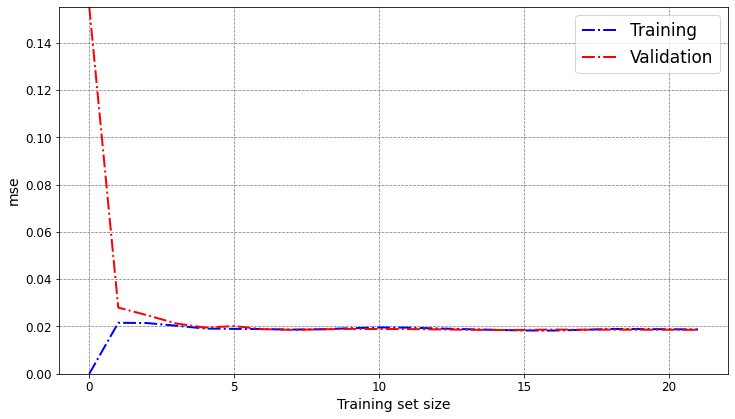

In [61]:
a = 0
b = 100
plot_train_vs_val(history_mlr.iloc[a:b,0], history_mlr.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

### Visualizo el training set y el validation set

In [65]:
Y_train_mlr = mlr.predict(X_train)
df_train_mlr = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_mlr)], axis = 1)

Y_val_mlr = mlr.predict(X_val)
df_val_mlr = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_mlr)], axis = 1)

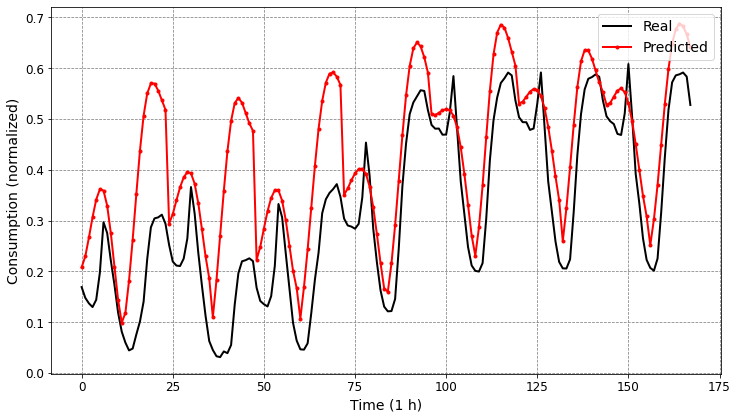

In [67]:
plot_hours(df_train_mlr.iloc[-1000:,:-12].to_numpy(), df_train_mlr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

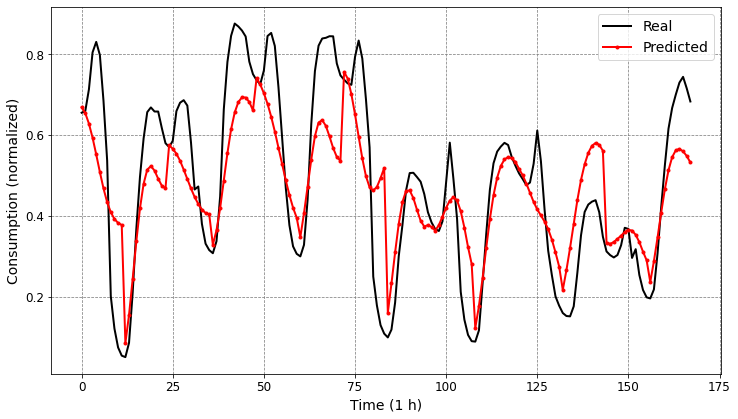

In [66]:
plot_hours(df_val_mlr.iloc[-1000:,:-12].to_numpy(), df_val_mlr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

In [109]:
errores_df.loc["mlr", "train mse"] = mean_squared_error(Y_train, mlr.predict(X_train))
errores_df.loc["mlr", "val mse"] = mean_squared_error(Y_val, mlr.predict(X_val))
errores_df.loc["mlr", "delta errores"] = errores_df.loc["mlr", "val mse"] - errores_df.loc["mlr", "train mse"] 
errores_df.loc["mlr", "n params"] = len(mlr.get_params())
errores_df.loc["mlr", "training time (s)"] = np.nan
errores_df.loc["mlr", "training prediction time (s)"] = np.nan
errores_df.loc["mlr", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rfr2,4.36e-03,6.80e-03,2.45e-03,1.80e+01,nan,nan,nan
rfr,9.50e-03,1.00e-02,5.00e-04,1.80e+01,nan,nan,nan
mdtr,9.66e-03,1.04e-02,7.33e-04,1.50e+01,nan,nan,nan
mlr,1.87e-02,1.86e-02,-1.71e-04,6.00e+00,nan,nan,nan
msvr,1.94e-02,1.90e-02,-3.32e-04,1.20e+01,nan,nan,nan
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan


### MSVR

(Multiple Support Vector Regression)

In [69]:
from sklearn.svm import LinearSVR

In [70]:
msvr = MultiOutputRegressor(LinearSVR(random_state = 42), n_jobs = -1)

In [71]:
history_msvr = ts_learning_curves(msvr, X_train, Y_train, X_val, Y_val, batch = 1024)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
training: 0 of 21029 current time: 0.17373132705688477 s
last training! current time: 31.70252251625061 s
tiempo de ejecución: 31.703365564346313 s


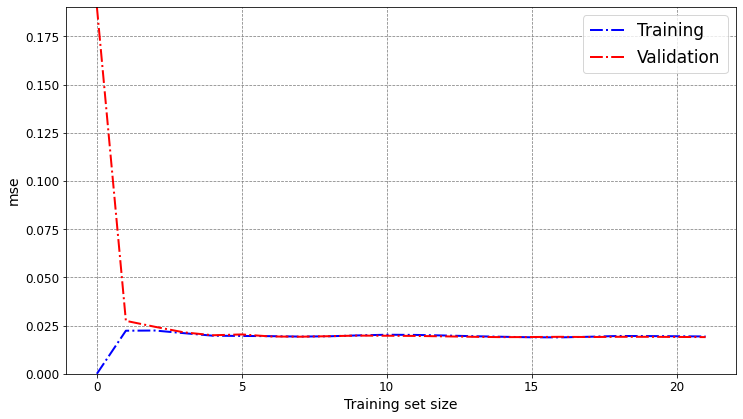

In [72]:
a = 0
b = 100
plot_train_vs_val(history_msvr.iloc[a:b,0], history_msvr.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

### Visualizo el training set y el validation set

In [73]:
Y_train_msvr = msvr.predict(X_train)
df_train_msvr = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_msvr)], axis = 1)

Y_val_msvr = msvr.predict(X_val)
df_val_msvr = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_msvr)], axis = 1)

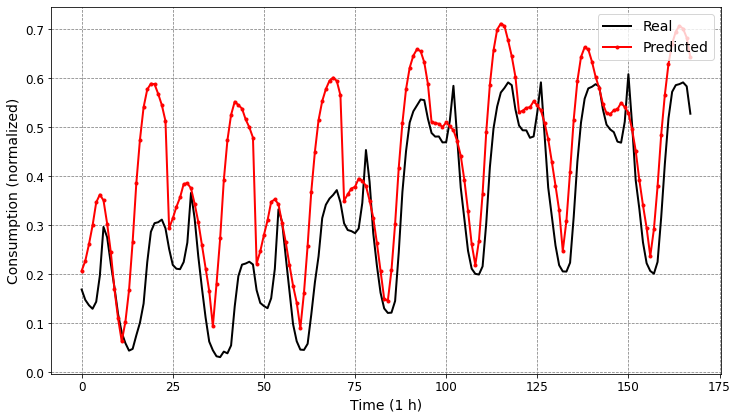

In [74]:
plot_hours(df_train_msvr.iloc[-1000:,:-12].to_numpy(), df_train_msvr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

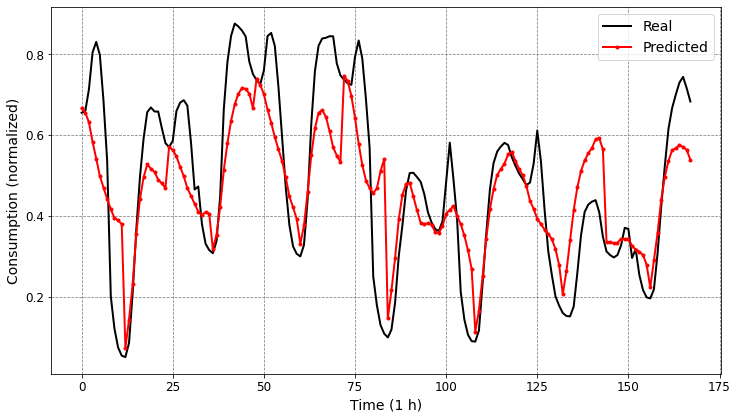

In [75]:
plot_hours(df_val_msvr.iloc[-1000:,:-12].to_numpy(), df_val_msvr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

In [108]:
errores_df.loc["msvr", "train mse"] = mean_squared_error(Y_train, msvr.predict(X_train))
errores_df.loc["msvr", "val mse"] = mean_squared_error(Y_val, msvr.predict(X_val))
errores_df.loc["msvr", "delta errores"] = errores_df.loc["msvr", "val mse"] - errores_df.loc["msvr", "train mse"]
errores_df.loc["msvr", "n params"] = len(msvr.get_params())
errores_df.loc["msvr", "training time (s)"] = np.nan
errores_df.loc["msvr", "training prediction time (s)"] = np.nan
errores_df.loc["msvr", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rfr2,4.36e-03,6.80e-03,2.45e-03,1.80e+01,nan,nan,nan
rfr,9.50e-03,1.00e-02,5.00e-04,1.80e+01,nan,nan,nan
mdtr,9.66e-03,1.04e-02,7.33e-04,1.50e+01,nan,nan,nan
mlr,1.87e-02,1.86e-02,1.71e-04,6.00e+00,nan,nan,nan
msvr,1.94e-02,1.90e-02,-3.32e-04,1.20e+01,nan,nan,nan
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan


### MDTR

(Multiple Decision Tree Regression)

In [77]:
from sklearn.tree import DecisionTreeRegressor

In [78]:
mdtr = MultiOutputRegressor(DecisionTreeRegressor(random_state = 42, max_depth = 5), n_jobs = -1)

In [79]:
history_mdtr = ts_learning_curves(mdtr, X_train, Y_train, X_val, Y_val, batch = 1024)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
training: 0 of 21029 current time: 0.32123303413391113 s
last training! current time: 11.613823890686035 s
tiempo de ejecución: 11.6151602268219 s


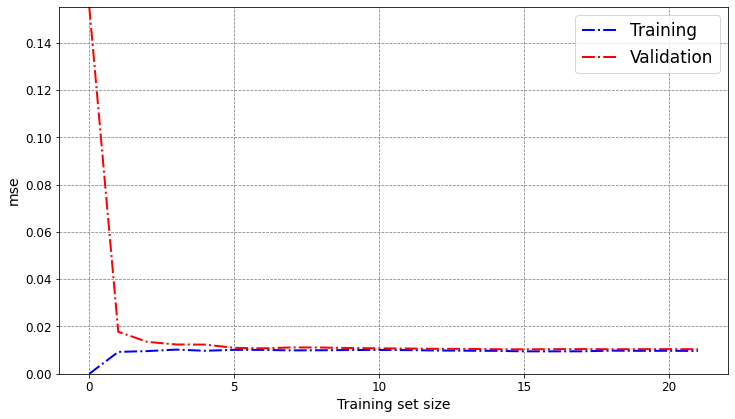

In [80]:
a = 0
b = 100
plot_train_vs_val(history_mdtr.iloc[a:b,0], history_mdtr.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

### Visualizo el training set y el validation set

In [81]:
Y_train_mdtr = mdtr.predict(X_train)
df_train_mdtr = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_mdtr)], axis = 1)

Y_val_mdtr = mdtr.predict(X_val)
df_val_mdtr = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_mdtr)], axis = 1)

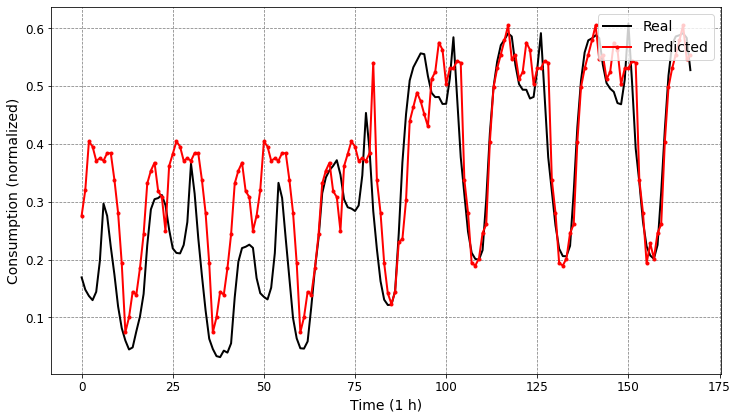

In [82]:
plot_hours(df_train_mdtr.iloc[-1000:,:-12].to_numpy(), df_train_mdtr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

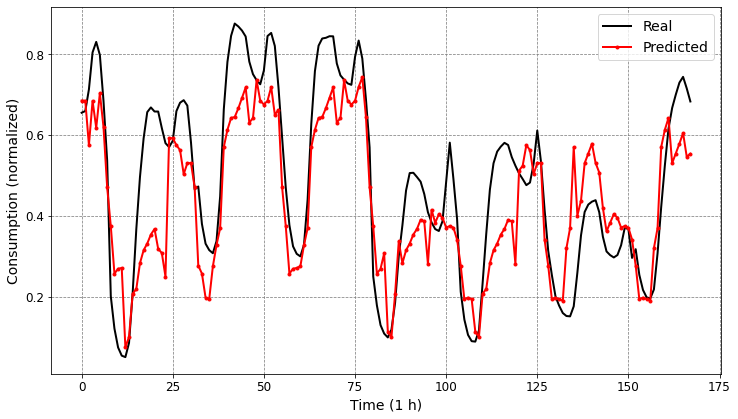

In [83]:
plot_hours(df_val_mdtr.iloc[-1000:,:-12].to_numpy(), df_val_mdtr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

In [107]:
errores_df.loc["mdtr", "train mse"] = mean_squared_error(Y_train, mdtr.predict(X_train))
errores_df.loc["mdtr", "val mse"] = mean_squared_error(Y_val, mdtr.predict(X_val))
errores_df.loc["mdtr", "delta errores"] = errores_df.loc["mdtr", "val mse"] - errores_df.loc["mdtr", "train mse"]
errores_df.loc["mdtr", "n params"] = len(mdtr.get_params())
errores_df.loc["mdtr", "training time (s)"] = np.nan
errores_df.loc["mdtr", "training prediction time (s)"] = np.nan
errores_df.loc["mdtr", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rfr2,4.36e-03,6.80e-03,2.45e-03,1.80e+01,nan,nan,nan
rfr,9.50e-03,1.00e-02,5.00e-04,1.80e+01,nan,nan,nan
mdtr,9.66e-03,1.04e-02,7.33e-04,1.50e+01,nan,nan,nan
mlr,1.87e-02,1.86e-02,1.71e-04,6.00e+00,nan,nan,nan
msvr,1.94e-02,1.90e-02,3.32e-04,1.20e+01,nan,nan,nan
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan


In [85]:
len(mdtr.estimators_)

12

### RFR

(Random Forest Regressor a modo de multiple output)

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
rfr = RandomForestRegressor(n_estimators = 24, max_depth = 5, n_jobs = -1, random_state = 42)

In [88]:
history_rfr = ts_learning_curves(rfr, X_train, Y_train, X_val, Y_val, batch = 1024)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
training: 0 of 21029 current time: 0.3603825569152832 s
last training! current time: 14.749211549758911 s
tiempo de ejecución: 14.749382495880127 s


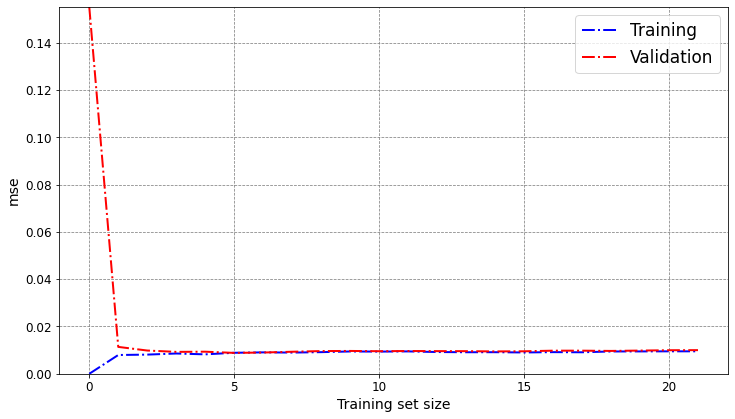

In [89]:
a = 0
b = 100
plot_train_vs_val(history_rfr.iloc[a:b,0], history_rfr.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

### Visualizo el training set y el validation set

In [90]:
Y_train_rfr = rfr.predict(X_train)
df_train_rfr = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_rfr)], axis = 1)

Y_val_rfr = mlr.predict(X_val)
df_val_rfr = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_rfr)], axis = 1)

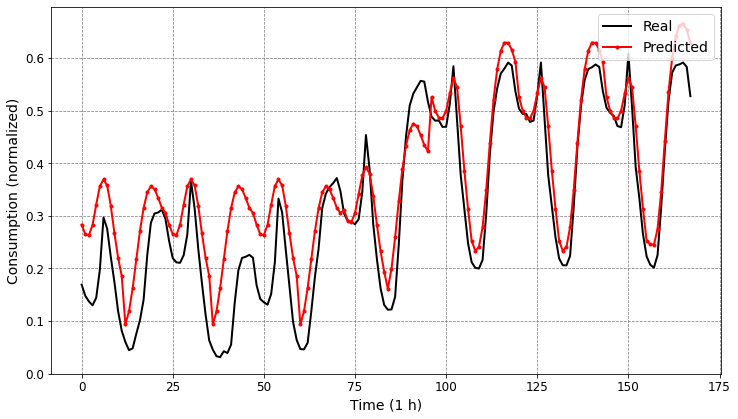

In [91]:
plot_hours(df_train_rfr.iloc[-1000:,:-12].to_numpy(), df_train_rfr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

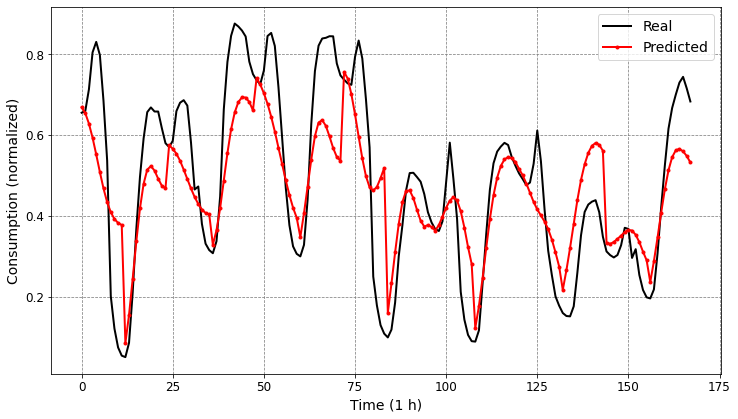

In [92]:
plot_hours(df_val_rfr.iloc[-1000:,:-12].to_numpy(), df_val_rfr.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

In [106]:
errores_df.loc["rfr", "train mse"] = mean_squared_error(Y_train, rfr.predict(X_train))
errores_df.loc["rfr", "val mse"] = mean_squared_error(Y_val, rfr.predict(X_val))
errores_df.loc["rfr", "delta errores"] = errores_df.loc["rfr", "val mse"] - errores_df.loc["rfr", "train mse"]
errores_df.loc["rfr", "n params"] = len(rfr.get_params())
errores_df.loc["rfr", "training time (s)"] = np.nan
errores_df.loc["rfr", "training prediction time (s)"] = np.nan
errores_df.loc["rfr", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rfr2,4.36e-03,6.80e-03,2.45e-03,1.80e+01,nan,nan,nan
rfr,9.50e-03,1.00e-02,5.00e-04,1.80e+01,nan,nan,nan
mdtr,9.66e-03,1.04e-02,7.33e-04,1.50e+01,nan,nan,nan
mlr,1.87e-02,1.86e-02,1.71e-04,6.00e+00,nan,nan,nan
msvr,1.94e-02,1.90e-02,3.32e-04,1.20e+01,nan,nan,nan
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan


### RFR 2

(Random Forest Regressor a modo de multiple output)

In [96]:
rfr2 = RandomForestRegressor(n_estimators = 50, max_depth = 10, n_jobs = -1, random_state = 42)

In [97]:
history_rfr2 = ts_learning_curves(rfr2, X_train, Y_train, X_val, Y_val, batch = 1024)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
training: 0 of 21029 current time: 0.7002332210540771 s
last training! current time: 30.649608612060547 s
tiempo de ejecución: 30.650405406951904 s


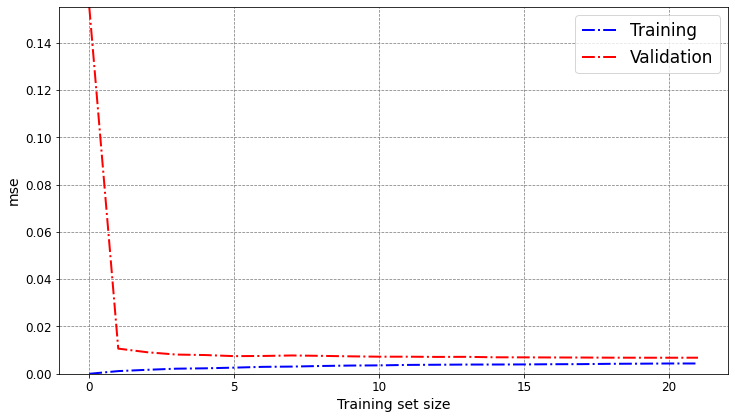

In [98]:
a = 0
b = 100
plot_train_vs_val(history_rfr2.iloc[a:b,0], history_rfr2.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

### Visualizo el training set y el validation set

In [99]:
Y_train_rfr2 = rfr2.predict(X_train)
df_train_rfr2 = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_rfr2)], axis = 1)

Y_val_rfr2 = rfr2.predict(X_val)
df_val_rfr2 = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_rfr2)], axis = 1)

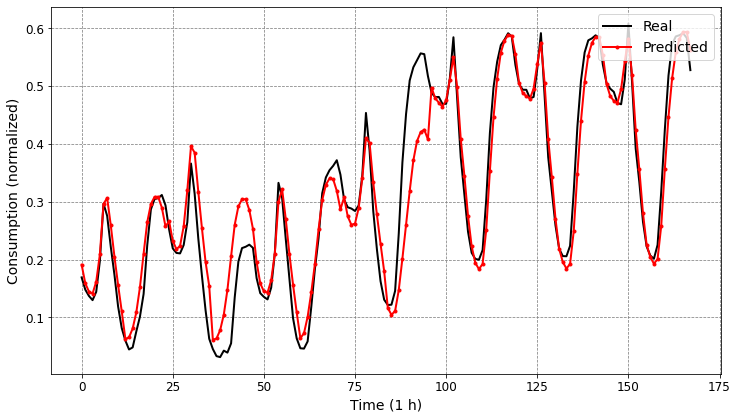

In [100]:
plot_hours(df_train_rfr2.iloc[-1000:,:-12].to_numpy(), df_train_rfr2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

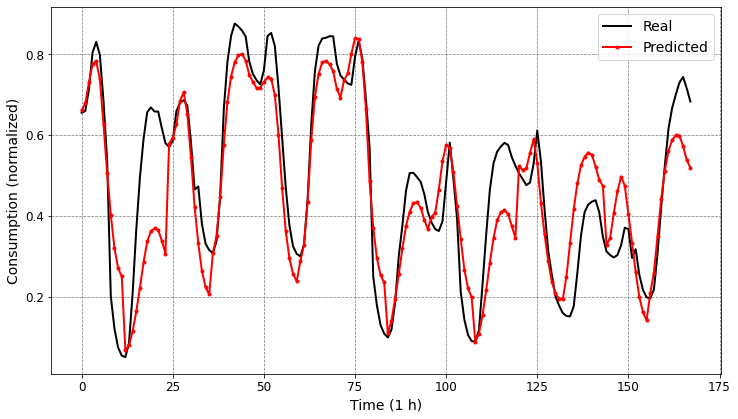

In [101]:
plot_hours(df_val_rfr2.iloc[-1000:,:-12].to_numpy(), df_val_rfr2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

In [105]:
errores_df.loc["rfr2", "train mse"] = mean_squared_error(Y_train, rfr2.predict(X_train))
errores_df.loc["rfr2", "val mse"] = mean_squared_error(Y_val, rfr2.predict(X_val))
errores_df.loc["rfr2", "delta errores"] = errores_df.loc["rfr2", "val mse"] - errores_df.loc["rfr2", "train mse"]
errores_df.loc["rfr2", "n params"] = len(rfr2.get_params())
errores_df.loc["rfr2", "training time (s)"] = np.nan
errores_df.loc["rfr2", "training prediction time (s)"] = np.nan
errores_df.loc["rfr2", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rfr2,4.36e-03,6.80e-03,2.45e-03,1.80e+01,nan,nan,nan
rfr,9.50e-03,1.00e-02,5.00e-04,1.80e+01,nan,nan,nan
mdtr,9.66e-03,1.04e-02,7.33e-04,1.50e+01,nan,nan,nan
mlr,1.87e-02,1.86e-02,1.71e-04,6.00e+00,nan,nan,nan
msvr,1.94e-02,1.90e-02,3.32e-04,1.20e+01,nan,nan,nan
naive_1h,7.89e-02,8.30e-02,4.12e-03,0.00e+00,nan,nan,nan
